In [102]:
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
import matplotlib.pyplot as plt
import contextily as ctx

using socrata to import the data from the two apis, will need to adjust the limits for valuation after we have app_tokens

In [104]:
client = Socrata("data.cityofnewyork.us", None)

In [105]:
#first one is the property valuation and assessment dataset
vresults = client.get("yjxr-fw8i", content_type='geojson', limit=200000)
value_gdf = gpd.GeoDataFrame.from_features(vresults, crs='EPSG:4326')

#second one is the assessment actions dataset
aresults = client.get("4nft-bihw", content_type='json', limit=100000) 
actions_df = pd.DataFrame.from_records(aresults)

plotting the property values one to see if the geodataframe worked

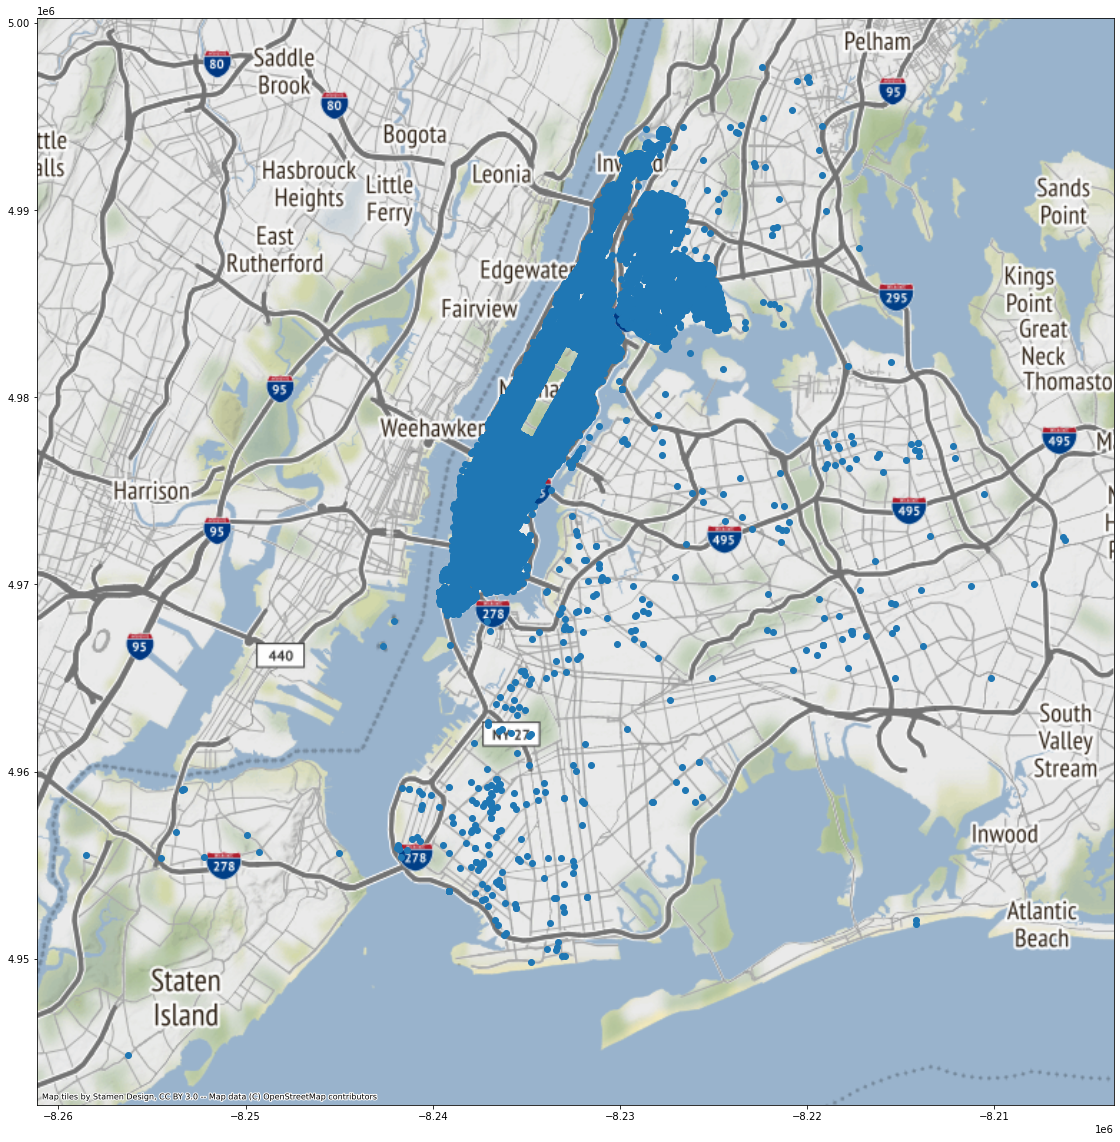

In [122]:
fig, ax = plt.subplots(figsize=(20,20))
value_gdf.to_crs('EPSG:3857').plot(ax=ax)
ctx.add_basemap(ax)

in order to combine the two datasets i made a new column in each that combines the borough, block, and lot numbers (keeping it as a string)

In [108]:
value_gdf['BBB'] = value_gdf['boro'] + '-' + value_gdf['block'] + '-' + value_gdf['lot']
value_gdf['BBB']

0           1-16-3859
1             1-73-28
2             1-73-29
3           1-29-7504
4             1-36-12
             ...     
199995      2-2878-81
199996    2-2748-1009
199997      2-2651-50
199998    2-2748-1030
199999     2-2272-109
Name: BBB, Length: 200000, dtype: object

In [109]:
actions_df['BBB'] = actions_df['borough_code'] + '-' + actions_df['block_number'] + '-' + actions_df['lot_number']
actions_df['BBB']

0            1-7-29
1            1-7-29
2            1-7-30
3            1-7-30
4            1-7-31
            ...    
12316    5-72614-11
12317     5-72616-1
12318     5-72616-1
12319     5-72830-5
12320     5-72830-5
Name: BBB, Length: 12321, dtype: object

next i set the indexes in each to the new BBB identifiers

In [111]:
actions_df.set_index('BBB', inplace=True)
value_gdf.set_index('BBB', inplace=True)

then i joined them using an inner join to just get the results where both datasets had the same BBB

we should probably double check this going forward and see if we missed any properties

In [113]:
joined_gdf = value_gdf.join(actions_df, how='inner', rsuffix=('_actions'))

In [114]:
print('number of properties that overlap between the two datasets is '+str(len(joined_gdf)))
print('actions dataset length is '+str(len(actions_df)))
print('valuation dataset length is '+str(len(value_gdf)))

number of properties that overlap between the two datasets is 5952
actions dataset length is 12321
valuation dataset length is 200000


In [115]:
#checking the columns

In [116]:
joined_gdf.columns

Index(['geometry', 'nta', 'avland', 'latitude', 'zip', 'stories', 'avtot',
       'easement', 'valtype', 'exland', 'blddepth', 'year', 'taxclass',
       'longitude', 'bldfront', 'bldgcl', 'block', 'avtot2', 'excd1', 'bble',
       'staddr', 'exmptcl', 'avland2', 'census_tract', 'lot', 'boro',
       'ltfront', 'fullval', 'ext', 'bin', 'excd2', 'owner', 'extot', 'extot2',
       'exland2', 'community_board', 'borough', 'period', 'council_district',
       'ltdepth', 'borough_code', 'block_number', 'lot_number', 'tax_year',
       'owner_name', 'property_address', 'granted_reduction_amount',
       'tax_class_code'],
      dtype='object')

converting the granted reduction amount value to a numeric value so it can be plotted

In [118]:
joined_gdf['granted_reduction_amount']=pd.to_numeric(joined_gdf['granted_reduction_amount'])

plotting the properties that have been granted reductions with marker size based on the reduction amount

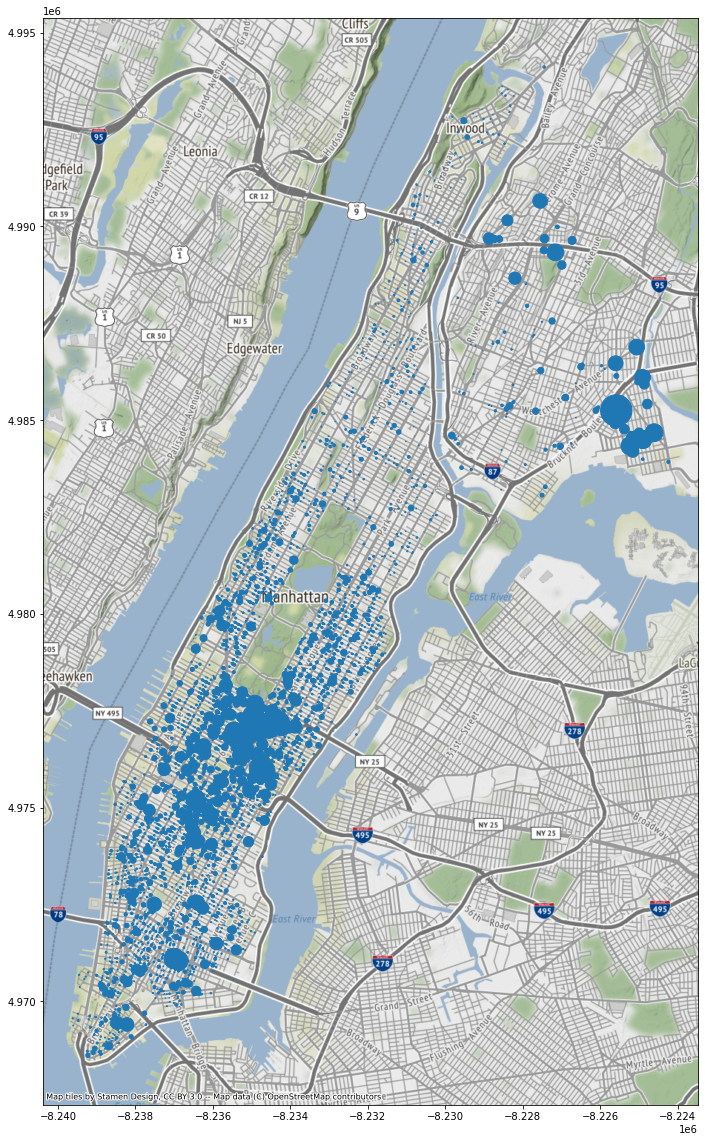

In [123]:
fig, ax = plt.subplots(figsize=(20,20))
joined_gdf.to_crs('EPSG:3857').plot(ax=ax, markersize=joined_gdf['granted_reduction_amount']/100000) #had to scale down by 100000 so that one point wouldn't just cover the whole map
ctx.add_basemap(ax)

**going forward we need:**
- to increase the size of the valuation dataset that we use (by getting an app_token)
- to figure out how to better visualize the reductions in value (some of the values are super different than others and there are going to be a bunch of points). maybe we plot them by borough?
- maybe spatial join to tracts so that we can summarize the data by census tracts